In [7]:
from datetime import datetime
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
from numpy_ext import rolling_apply


#gpx_path = open('gtfs/data/user_data/user_1_profile.gpx', 'r')


with open('/home/pablo/PycharmProjects/lbrp/gtfs/data/user_data/user_1_profile.gpx') as f:
    gpx = gpxpy.parse(f)

In [8]:
# Convert to a dataframe one point at a time.
points = []
for segment in gpx.tracks[0].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
df = pd.DataFrame.from_records(points)

In [9]:
# Cumulative distance.
coords = [(p.latitude, p.longitude) for p in df.itertuples()]
df['distance'] = [0] + [geopy.distance.distance(from_, to).m for from_, to in zip(coords[:-1], coords[1:])]
df['cumulative_distance'] = df.distance.cumsum()
# Timing.
df['duration'] = df.time.diff().dt.total_seconds().fillna(0)
df['cumulative_duration'] = df.duration.cumsum()
df['pace_metric'] = pd.Series((df.duration / 60) / (df.distance / 1000)).bfill()

df


,time,latitude,longitude,elevation,distance,cumulative_distance,duration,cumulative_duration,pace_metric
0,2024-03-01 08:00:00,59.307087,18.040131,0.0,0.000000,0.000000,0.0,0.0,221.178736
1,2024-03-01 16:00:00,59.288575,18.028272,0.0,2170.190539,2170.190539,28800.0,28800.0,221.178736
2,2024-03-02 00:00:00,59.329300,18.068600,0.0,5085.217538,7255.408076,28800.0,57600.0,94.391242
3,2024-03-02 01:00:00,59.332923,18.115912,0.0,2723.166898,9978.574974,3600.0,61200.0,22.033170
4,2024-03-02 03:00:00,59.334504,18.101540,0.0,836.729885,10815.304859,7200.0,68400.0,143.415458
...,...,...,...,...,...,...,...,...,...
205,2024-03-31 01:00:00,59.375782,18.031225,0.0,5597.706731,890509.516353,3600.0,2566800.0,10.718675
206,2024-03-31 03:00:00,59.366719,18.062631,0.0,2051.296041,892560.812394,7200.0,2574000.0,58.499601
207,2024-03-31 05:00:00,59.351544,18.059598,0.0,1699.254019,894260.066413,7200.0,2581200.0,70.619224
208,2024-03-31 06:00:00,59.326249,18.115520,0.0,4250.780898,898510.847311,3600.0,2584800.0,14.115054


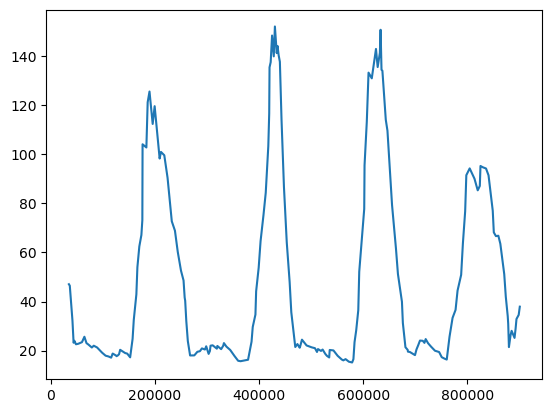

In [10]:
def rolling_metric_pace(duration, distance):
    return (duration.sum() / 60) / (distance.sum() / 1000)


x = df.cumulative_distance
y = rolling_apply(rolling_metric_pace, 10, df.duration.values, df.distance.values)

plt.plot(x, y)

In [6]:
import fiona
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape

